In [1]:
import h5py
from matplotlib import colors
import matplotlib.pyplot as plt
import multiprocessing
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import ssm
from ssm.util import find_permutation
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from up_down import get_up_down
from utils import get_sample_interval, load, save

In [2]:
# filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/home/adameisen/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]
print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 88.53 seconds)


In [24]:
# Set the parameters of the SLDS
latent_dim = 7 # number of latent dimensions
emissions_dim = lfp.shape[1]      # number of observed dimensions

# areas = ['vlPFC', 'FEF', 'CPB', '7b']
areas = np.unique(electrode_info['area'])
unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]
stride = 100 # s
duration = 10 # s

start_times = np.arange(0, lfp.shape[0]*dt - duration + 0.1, stride).astype(int)

In [55]:
param_list = []
for start_time in start_times:
    start_step = int(start_time/dt)
    length = int(duration/dt)
    data = lfp[start_step:start_step + length, unit_indices]
    var_names = [f"unit_{unit_num} {electrode_info['area'][unit_num]}" for unit_num in unit_indices]
    param_list.append((start_time, duration, start_step, length, data, var_names, emissions_dim, n_disc_states, latent_dim))

In [56]:
def slds_eigs_worker(param_tuple):
    (start_time, duration, start_step, length, data, var_names, emissions_dim, n_disc_states, latent_dim) = param_tuple
    
    # Create the model and initialize its parameters
    slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, transitions="recurrent_only", emissions="gaussian_orthog", verbose=False)

    # Fit the model using Laplace-EM with a structured variational posterior
    q_lem_elbos, q_lem = slds.fit(data, method="laplace_em",
                                   variational_posterior="structured_meanfield",
                                   num_iters=10, alpha=0.0, verbose=False)
     
    criticality_inds = np.zeros((n_disc_states, latent_dim))
    eigs = np.zeros((n_disc_states, latent_dim), dtype='complex')
    for i in range(n_disc_states):
        eigs[i] = np.linalg.eig(slds.dynamics._As[i])[0]
        criticality_inds[i] = np.abs(eigs[i])
        criticality_inds[i].sort()
        criticality_inds[i] = criticality_inds[i][::-1]
    
    q_lem_x = q_lem.mean_continuous_states[0]
    preds = slds.smooth(q_lem_x, data)
    mse = ((preds - data)**2).mean()
    
    disc_states = slds.most_likely_states(q_lem_x, data)

    return dict(
        start_time=start_time,
        duration=duration,
        start_step=start_step,
        length=length,
        slds=slds,
        q_lem_elbos=q_lem_elbos,
        q_lem=q_lem,
        eigs=eigs,
        criticality_inds=criticality_inds,
        mse=mse,
        disc_states=disc_states
    )

In [57]:
results = []
for params in tqdm(param_list):
    results.append(slds_eigs_worker(params))

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Plot

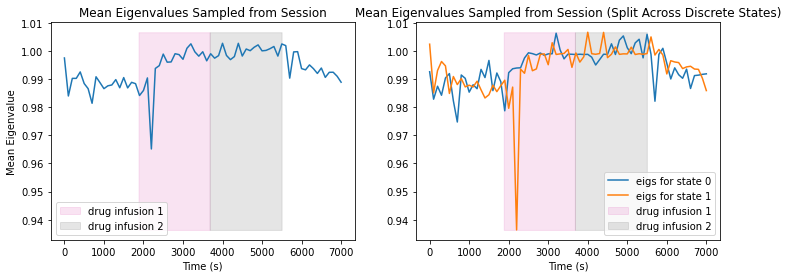

In [34]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

ax = axs[0]
mean_eigs = np.array([results[i]['criticality_inds'].mean() for i in range(len(results))])
ax.plot(start_times, mean_eigs)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean Eigenvalue')
ax.set_title("Mean Eigenvalues Sampled from Session")


ax = axs[1]
mean_eigs = np.array([results[i]['criticality_inds'].mean(axis=1) for i in range(len(results))])
for i in range(n_disc_states):
    ax.plot(start_times, mean_eigs[:, i], label=f'eigs for state {i}')
ax.set_xlabel('Time (s)')
# ax.set_ylabel('Mean Eigenvalue')
ax.set_title("Mean Eigenvalues Sampled from Session (Split Across Discrete States)")
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')
ax.legend()
ax.yaxis.set_tick_params(labelbottom=True)

# make coloured portions the same size
ax = axs[0]
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')
ax.legend()

plt.show()

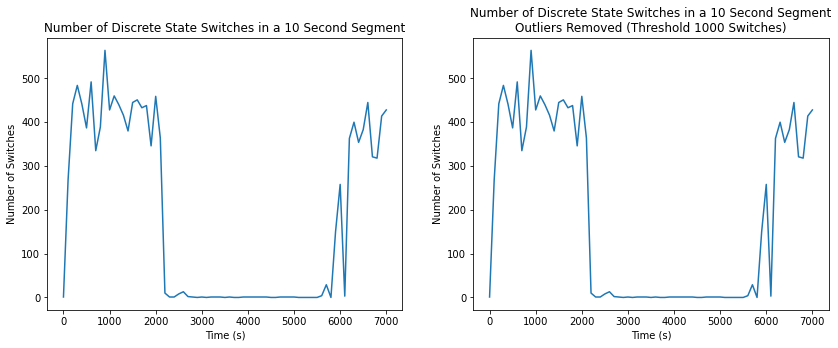

In [36]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
num_switches = np.array([np.sum(np.diff(results[i]['disc_states']) != 0) for i in range(len(results))])
plt.plot(start_times, num_switches)
plt.title(f"Number of Discrete State Switches in a {duration} Second Segment")
plt.xlabel('Time (s)')
plt.ylabel('Number of Switches')

plt.subplot(1, 2, 2)
thresh = 1000
num_switches[num_switches > thresh] = num_switches[num_switches <= thresh].mean()
plt.plot(start_times, num_switches)
plt.title(f"Number of Discrete State Switches in a {duration} Second Segment\nOutliers Removed (Threshold {thresh} Switches)")
plt.xlabel('Time (s)')
plt.ylabel('Number of Switches')

plt.show()

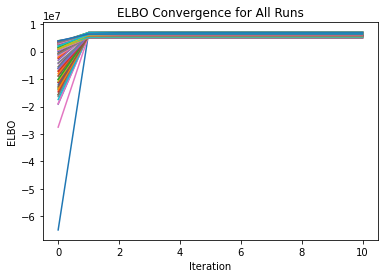

In [37]:
for i in range(len(results)):
    plt.plot(results[i]['q_lem_elbos'])
plt.title("ELBO Convergence for All Runs")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()

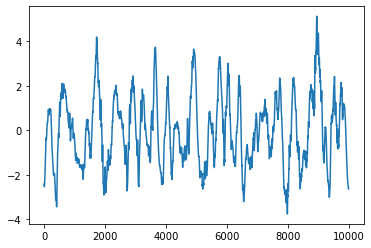

In [54]:
# for i in range(7):
for i in [2]:
    plt.plot(results[56]['q_lem'].mean_continuous_states[0][:, i])

In [61]:
data_dir = "../../__data__/slds/"
os.makedirs(data_dir, exist_ok=True)
f = h5py.File(os.path.join(data_dir, 'MyDataset.h5'), 'a')

In [78]:
import functools

In [79]:
functools.partial

functools.partial

In [81]:
lfp.shape[0]

7085396

In [82]:
duration = lfp.shape[0]*dt # s
length = int(duration/dt)

start_times = np.arange(0, lfp.shape[0]*dt - duration + 0.1, stride).astype(int)

In [1]:
start_times

NameError: name 'start_times' is not defined

In [84]:
duration

7085.396

In [85]:
lfp2 = lfp[:10000]

In [86]:
lfp2.shape

(10000, 253)